# Biostat M280 Homework 2

**Due May 11 @ 11:59PM**

## Q1. Nonnegative Matrix Factorization

Nonnegative matrix factorization (NNMF) was introduced by [Lee and Seung (1999)](https://www.nature.com/articles/44565) as an analog of principal components and vector quantization with applications in data compression and clustering. In this homework we consider algorithms for fitting NNMF and (optionally) high performance computing using graphical processing units (GPUs).

<img src="./nnmf.png" width="500" align="center"/>

In mathematical terms, one approximates a data matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ with nonnegative entries $x_{ij}$ by a product of two low-rank matrices $\mathbf{V} \in \mathbb{R}^{m \times r}$ and $\mathbf{W} \in \mathbb{R}^{r \times n}$ with nonnegative entries $v_{ik}$ and $w_{kj}$. Consider minimization of the squared Frobenius norm
$$
	L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$
which should lead to a good factorization. Later in the course we will learn how to derive a majorization-minimization (MM) algorithm with iterative updates
$$
	v_{ik}^{(t+1)} = v_{ik}^{(t)} \frac{\sum_j x_{ij} w_{kj}^{(t)}}{\sum_j b_{ij}^{(t)} w_{kj}^{(t)}}, \quad \text{where } b_{ij}^{(t)} = \sum_k v_{ik}^{(t)} w_{kj}^{(t)},
$$
$$
	w_{kj}^{(t+1)} = w_{kj}^{(t)} \frac{\sum_i x_{ij} v_{ik}^{(t+1)}}{\sum_i b_{ij}^{(t+1/2)} v_{ik}^{(t+1)}}, \quad \text{where } b_{ij}^{(t+1/2)} = \sum_k v_{ik}^{(t+1)} w_{kj}^{(t)}
$$
that drive the objective $L^{(t)} = L(\mathbf{V}^{(t)}, \mathbf{W}^{(t)})$ downhill. Superscript $t$ indicates iteration number. Efficiency (both speed and memory) will be the most important criterion when grading this problem.


1. Implement the algorithm with arguments: $\mathbf{X}$ (data, each row is a vectorized image), rank $r$, convergence tolerance, and optional starting point.
```julia
function nnmf(
    X::Matrix{T},
    r::Integer;
    maxiter::Integer=1000, 
    tol::Number=1e-4,
    V::Matrix{T}=rand(T, size(X, 1), r),
    W::Matrix{T}=rand(T, r, size(X, 2))
    ) where T <: AbstractFloat
    # implementation
    # Output
    return V, W
end
```

0. Database 1 from the [MIT Center for Biological and Computational Learning (CBCL)](http://cbcl.mit.edu) reduces to a matrix $\mathbf{X}$ containing $m = 2,429$ gray-scale face images with $n = 19 \times 19 = 361$ pixels per face. Each image (row) is scaled to have mean and standard deviation 0.25.  
Read in the [`nnmf-2429-by-361-face.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/nnmf-2429-by-361-face.txt) file, e.g., using [`readdlm()`](https://docs.julialang.org/en/stable/stdlib/io-network/#Base.DataFmt.readdlm-Tuple{Any,Char,Type,Char}) function, and display a couple sample images, e.g., using [ImageView.jl](https://github.com/JuliaImages/ImageView.jl) package.

0. Report the run times, using `@time`, of your function for fitting NNMF on the MIT CBCL face data set at ranks $r=10, 20, 30, 40, 50$. For ease of comparison (and grading), please start your algorithm with the provided $\mathbf{V}^{(0)}$ (first $r$ columns of [`V0.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/V0.txt)) and $\mathbf{W}^{(0)}$ (first $r$ rows of [`W0.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/W0.txt)) and stopping criterion
$$
	\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$

0. Choose an $r \in \{10, 20, 30, 40, 50\}$ and start your algorithm from a different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

0. For the same $r$, start your algorithm from $v_{ik}^{(0)} = w_{kj}^{(0)} = 1$ for all $i,j,k$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

0. Plot the basis images (rows of $\mathbf{W}$) at rank $r=50$. What do you find?

0. (Optional) Investigate the GPU capabilities of Julia. Report the speed gain of your GPU code over CPU code at ranks $r=10, 20, 30, 40, 50$. Make sure to use the same starting point as in part 2.

### Answer to Q1(2)

In [1]:
# Load dataset
data_loc = "nnmf-2429-by-361-face.txt"
X = readdlm(data_loc);

In [2]:
Pkg.add("ImageView")
Pkg.add("Distances")
using ImageView, Images
using Distances
using Plots

INFO: Package ImageView is already installed
INFO: METADATA is out-of-date — you may not have the latest version of ImageView
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Package Distances is already installed
INFO: METADATA is out-of-date — you may not have the latest version of Distances
INFO: Use `Pkg.update()` to get the latest versions of your packages


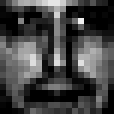

In [5]:
# Display the image
# Reshape the row vector to an 19*19 image
img = reshape(X[1, :], 19, 19);
# Display the image by converting the to Grayscale image
img = colorview(Gray, img)  
# convert(Array, img)

### Answer to Q1(1)

In [6]:
# Define and implement NNMF algorithm
function nnmf(
    X::Matrix, 
    r::Int;
    maxiter::Int=1000, 
    tol::eltype(X)=1e-4,
    V::Matrix{eltype(X)}=rand(size(X, 1), r),
    W::Matrix{eltype(X)}=rand(r, size(X, 2))
 )
    pre_err = 0.0
    err_change = 1000.0
    t = Int(0)
    while err_change > tol
        if t > maxiter
            return V, W
        end
        # B = *(V, W)
        V = V .* (X * W') ./ (V * W * W')
        B = V * W
        W = W .* (V' * X) ./ (V' * B)
        t = t + 1;
        err = sqeuclidean(X, B)
        err_change = abs(err - pre_err) / (pre_err + 1)
        pre_err = err
       
        # println(err_change)
    end
    return V, W, pre_err
 # implementation
end

nnmf (generic function with 1 method)

### Answer to Q1(3)

In [7]:
v_data_loc = "V0.txt"
w_data_loc = "W0.txt"
V_init = readdlm(v_data_loc);
W_init = readdlm(w_data_loc);

In [24]:
# Report time r = 10
r = 10
@time V, W, pre_err = nnmf(X, r, V = V_init[:, 1:r], W = W_init[1:r, :]);

  5.991769 seconds (4.80 k allocations: 3.279 GiB, 11.46% gc time)


In [25]:
# Report time r = 20
r = 20
@time V, W, pre_err = nnmf(X, r, V = V_init[:, 1:r], W = W_init[1:r, :]);

 10.966193 seconds (7.90 k allocations: 5.662 GiB, 11.23% gc time)


In [26]:
# Report time r = 30
r = 30
@time V, W, pre_err = nnmf(X, r, V = V_init[:, 1:r], W = W_init[1:r, :]);

 15.076644 seconds (9.66 k allocations: 7.240 GiB, 9.56% gc time)


In [27]:
# Report time r = 40
r = 40
@time V, W, pre_err = nnmf(X, r, V = V_init[:, 1:r], W = W_init[1:r, :]);

 19.168610 seconds (11.64 k allocations: 9.105 GiB, 9.03% gc time)


In [28]:
# Report time r = 50
r = 50
@time V, W, pre_err = nnmf(X, r, V = V_init[:, 1:r], W = W_init[1:r, :]);

 26.059584 seconds (13.98 k allocations: 11.392 GiB, 7.91% gc time)


### Answer to Q1(4)  

I select r = 20, and run the algorithm with predefined V, W or random V, W.  

The following shows that different start points can lead to different solutions.   
The objective function may not be convex, and could have many different local minimums. The iterative algorithm can converge at different local minimums, which cause different solutions. 

In [44]:
# Select r = 20, first get result using pre-defined V, W
r = 20
srand(1234)
V1, W1, pre_err1 = nnmf(X, r, V = V_init[:, 1:r], W = W_init[1:r, :]);

V2, W2, pre_err2 = 
    nnmf(X, r, V = rand(size(X, 1), r), W = rand(r, size(X, 2)));
println(pre_err1 == pre_err2)
println(V1 == V2)
println(W1 == W2)

false
false
false


### Answer to Q1(5)  

The following shows that if the start point is same, the algorithm will arrive at the same local minimum. 

In [47]:
V3, W3, pre_err3 = 
    nnmf(X, r, V = ones(size(X, 1), r), W = ones(r, size(X, 2)));
V4, W4, pre_err4 = 
    nnmf(X, r, V = ones(size(X, 1), r), W = ones(r, size(X, 2)));
println(pre_err3 == pre_err4)
println(V3 == V4)
println(W3 == W4)

true
true
true


### Answer to Q1(6)  

The following shows basis images from rows of W. We can see each basis image captures different compoments of a face: eyes, mouth, etc. 

In [33]:
# r = 50
r = 50
V, W, pre_err = nnmf(X, r, V = V_init[:, 1:r], W = W_init[1:r, :]);

In [31]:
large_im = zeros(190, 95)
num_cols = 5
num_rows = 10
counter = 1
for i = 1: num_rows
    for j = 1: num_cols
        large_im[(i - 1) * 19 + 1: i * 19, (j - 1) * 19 + 1: j * 19] = reshape(W[counter, :], 19, 19)
        counter += 1
    end
end



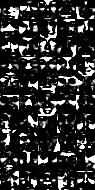

In [32]:
colorview(Gray, large_im)

In [27]:
grid, frames, canvases = canvasgrid((10, 5));
#colorview(Gray, large_im)  
counter = 1
for i = 1: num_rows
    for j = 1: num_cols
        imshow(canvases[i, j], colorview(Gray, reshape(W[counter, :], 19, 19)))
        counter += 1
    end
end

In [28]:
using Gtk.ShortNames
win = Window(grid)
showall(win)

Gtk.GtkWindowLeaf(name="", parent, width-request=-1, height-request=-1, visible=TRUE, sensitive=TRUE, app-paintable=FALSE, can-focus=FALSE, has-focus=FALSE, is-focus=FALSE, focus-on-click=TRUE, can-default=FALSE, has-default=FALSE, receives-default=FALSE, composite-child=FALSE, style, events=0, no-show-all=FALSE, has-tooltip=FALSE, tooltip-markup=NULL, tooltip-text=NULL, window, opacity=1.000000, double-buffered, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-left, margin-right, margin-start=0, margin-end=0, margin-top=0, margin-bottom=0, margin=0, hexpand=FALSE, vexpand=FALSE, hexpand-set=FALSE, vexpand-set=FALSE, expand=FALSE, scale-factor=2, border-width=0, resize-mode, child, type=GTK_WINDOW_TOPLEVEL, title=NULL, role=NULL, resizable=TRUE, modal=FALSE, window-position=GTK_WIN_POS_NONE, default-width=-1, default-height=-1, destroy-with-parent=FALSE, hide-titlebar-when-maximized=FALSE, icon, icon-name=NULL, screen, type-hint=GDK_WINDOW_TYPE_HINT_NORMAL, skip-taskbar-hint=FALSE,

## Q2. Linear Mixed Models

Consider a linear mixed effects model
$$
	y_i = \mathbf{x}_i^T \beta + \mathbf{z}_i^T \gamma + \epsilon_i, \quad i=1,\ldots,n,
$$
where $\epsilon_i$ are independent normal errors $N(0,\sigma_0^2)$, $\beta \in \mathbb{R}^p$ are fixed effects, and $\gamma \in \mathbb{R}^q$ are random effects assumed to be $N(\mathbf{0}_q, \sigma_1^2 \mathbf{I}_q$) independent of $\epsilon_i$. 

0. Show that 
$$
    \mathbf{y} \sim N \left( \mathbf{X} \beta, \sigma_0^2 \mathbf{I}_n + \sigma_1^2 \mathbf{Z} \mathbf{Z}^T \right),
$$
where $\mathbf{y} = (y_1, \ldots, y_n)^T \in \mathbb{R}^n$, $\mathbf{X} = (\mathbf{x}_1, \ldots, \mathbf{x}_n)^T \in \mathbb{R}^{n \times p}$, and $\mathbf{Z} = (\mathbf{z}_1, \ldots, \mathbf{z}_n)^T \in \mathbb{R}^{n \times q}$. 

0. Write a function, with interface 
    ```julia
    logpdf_mvn(y::Vector, Z::Matrix, σ0::Number, σ1::Number),
    ```
that evaluates the log-density of a multivariate normal with mean $\mathbf{0}$ and covariance $\sigma_0^2 \mathbf{I} + \sigma_1^2 \mathbf{Z} \mathbf{Z}^T$ at $\mathbf{y}$. Make your code efficient in the $n \gg q$ case. 

0. Compare your result (both accuracy and timing) to the [Distributions.jl](http://distributionsjl.readthedocs.io/en/latest/multivariate.html#multivariate-normal-distribution) package using following data.  
    ```julia
    using BenchmarkTools, Distributions

    srand(280)
    n, q = 2000, 10
    Z = randn(n, q)
    σ0, σ1 = 0.5, 2.0
    Σ = σ1^2 * Z * Z.' + σ0^2 * I
    mvn = MvNormal(Σ) # MVN(0, Σ)
    y = rand(mvn) # generate one instance from MNV(0, Σ)

    # check you answer matches that from Distributions.jl
    @show logpdf_mvn(y, Z, σ0, σ1)
    @show logpdf(mvn, y)

    # benchmark
    @benchmark logpdf_mvn(y, Z, σ0, σ1)
    @benchmark logpdf(mvn, y)
    ```

### Answer to Q2(1)  

The function can be proved using the characteristic function.   

Since $\mathbf{\epsilon} \sim N(0,\sigma_0^2)$ and $\mathbfgamma \sim N(\mathbf{0}_q, \sigma_1^2 \mathbf{I}_q$)

In [54]:
function logpdf_mvn(y::Vector, Z::Matrix, σ0::Number, σ1::Number)
    # compute convariance matrix
    Σ = σ1^2 * Z * Z.' + σ0^2 * I
    n = length(y)
    Σchol = cholfact(Σ)
    -(n//2) * log(2π) - (1//2) * logdet(Σchol) - (1//2) * sum(abs2, Σchol[:L] \ y)
    
end


logpdf_mvn (generic function with 1 method)

In [55]:
using BenchmarkTools, Distributions

srand(280)
n, q = 2000, 10
Z = randn(n, q)
σ0, σ1 = 0.5, 2.0
Σ = σ1^2 * Z * Z.' + σ0^2 * I
mvn = MvNormal(Σ) # MVN(0, Σ)
y = rand(mvn) # generate one instance from MNV(0, Σ)

# check you answer matches that from Distributions.jl
@show logpdf_mvn(y, Z, σ0, σ1)
@show logpdf(mvn, y)

logpdf_mvn(y, Z, σ0, σ1) = -1571.5736734654163
logpdf(mvn, y) = -1571.573673465417


-1571.573673465417

In [56]:
# benchmark
@benchmark logpdf_mvn(y, Z, σ0, σ1)

BenchmarkTools.Trial: 
  memory estimate:  122.39 MiB
  allocs estimate:  23
  --------------
  minimum time:     223.554 ms (15.29% GC)
  median time:      393.602 ms (16.03% GC)
  mean time:        353.480 ms (33.02% GC)
  maximum time:     606.963 ms (6.42% GC)
  --------------
  samples:          15
  evals/sample:     1

In [57]:
@benchmark logpdf(mvn, y)

BenchmarkTools.Trial: 
  memory estimate:  15.78 KiB
  allocs estimate:  3
  --------------
  minimum time:     6.223 ms (0.00% GC)
  median time:      10.645 ms (0.00% GC)
  mean time:        10.346 ms (0.00% GC)
  maximum time:     13.287 ms (0.00% GC)
  --------------
  samples:          482
  evals/sample:     1